<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

**Проверим меняется что-то или нет**

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [2]:
#для начала импортируем необходимую библиотеку

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [3]:
# снятие ограничений по просмотру,
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [4]:
# обработаем ошибку для возможности работы локально и в тренажере
# прочитаем массивы и посмотрим что в них:

try:
    df = pd.read_csv('/Users/vladimir_volimbovskiy/Data_Science/module_2/Sprint_3/Churn.csv')
       
except FileNotFoundError as e:
    print(repr(e))
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
    
    
df.info() 

display(df.head())

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
# в встолбце - Tenure меньше значений, чем в остальных - заменим их на 0, это поможет нам при обучении модели
df = df.fillna(0)
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Вывод** 


Прежде чем приступить к выволнению задания мы проанализировали массив: из чего он состоит, какие есть столбцы, какие данные.


Факт ухода клиента идет по признаку - 0 и 1, ушел или нет соотвественно.


Целевым показателем как раз будем использовать столбец с данными по уходу клиентов, для обучения моделей.

Убрали пустые значения из столбца о количестве лет сотрудничества, инчае модель не будет обучаться.

## Исследование задачи

In [6]:
# честно говоря, не очень понимаю, что здесь нужно сделать, поэтому просто посмотрю на баланс классов
# посмотрим на сбалансированность данных:

display(df.pivot_table(index = 'Exited', values='Gender',aggfunc='count'))


# у нас существенный перекос в пользу клиентов, которые ушли 80% и 20% клиентов, которые остались

,Gender
Exited,
0,7963
1,2037


In [7]:
# Тк будет использовать регрессию, то во всех столбцах необходимы цифровые значения
# преобразуем все категориальные значения в цифры:

encoder = OrdinalEncoder()
df = pd.DataFrame(encoder.fit_transform(df),
                            columns=df.columns)

In [8]:
# перед извлчением выборки, сформируем массив и целевые признаки

features = df.drop(['Exited'], axis =1) 
target = df['Exited'] 

# сформируем тестовые и валидационные выборки


features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size= 0.20, random_state=12345, stratify=target)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size= 0.25, random_state=12345, stratify=target_train)

In [9]:
# проверим, корректное ли разделение:
display(df.shape,features_train.shape,features_test.shape,features_valid.shape)

# все верно

(10000, 14)

(6000, 13)

(2000, 13)

(2000, 13)

In [10]:
# перед исследованием создадим несколько моделей:

# посмотрим работают ли модели и какая у них точность и на каккой глубине
# дерево решений

for depth in range(1, 11):
    model_1 = DecisionTreeClassifier(random_state=12345, max_depth= depth) 

    model_1.fit(features_train, target_train)

    predictions_valid = model_1.predict(features_valid)

    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))

max_depth = 1 : 0.7965
max_depth = 2 : 0.836
max_depth = 3 : 0.835
max_depth = 4 : 0.8495
max_depth = 5 : 0.8535
max_depth = 6 : 0.8495
max_depth = 7 : 0.844
max_depth = 8 : 0.84
max_depth = 9 : 0.8425
max_depth = 10 : 0.8315


In [11]:
# сделаем случайный лес, где подбор параметров будет через GridSearch
clf = RandomForestClassifier(random_state=12345)

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train,target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

In [12]:
clf_score = grid.score(features_valid, target_valid)
print(clf_score)
grid.best_params_

0.856


{'max_depth': 11,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 40}

In [13]:
# логистическая регрессия
model_3 = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 

model_3.fit(features_train,target_train)
predictions_valid = model_3.predict(features_valid) 

print(accuracy_score(target_valid, predictions_valid))

0.8185


## Борьба с дисбалансом

In [14]:
# воспользуемся методом увеличения выборки
# разделим обучающую выборку на отрицательные и положительные объекты.
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

In [15]:
print(target_upsampled.sum())
print(features_upsampled.shape)

6115.0
(10892, 13)


In [16]:
for depth in range(1, 11):
    model_1 = DecisionTreeClassifier(random_state=12345, max_depth= depth) 

    model_1.fit(features_upsampled, target_upsampled)

    predictions_valid = model_1.predict(features_valid)

    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))

max_depth = 1 : 0.7
max_depth = 2 : 0.701
max_depth = 3 : 0.701
max_depth = 4 : 0.6735
max_depth = 5 : 0.753
max_depth = 6 : 0.7265
max_depth = 7 : 0.749
max_depth = 8 : 0.7225
max_depth = 9 : 0.7215
max_depth = 10 : 0.73


In [17]:
# сделаем случайный лес, где подбор параметров будет через GridSearch
clf = RandomForestClassifier(random_state=12345)

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_upsampled, target_upsampled)

clf_score = grid.score(features_valid, target_valid)
print(clf_score)
grid.best_params_

0.8115


{'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [18]:
# логистическая регрессия
model_3 = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 

model_3.fit(features_upsampled, target_upsampled)
predictions_valid = model_3.predict(features_valid) 

print(accuracy_score(target_valid, predictions_valid))

0.6335


In [19]:
# метод уменьшенеия выборки

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.9)



In [20]:
print(features_downsampled.shape)
#print(target_downsampled.shape)

(5522, 13)


In [21]:
for depth in range(1, 11):
    model_1_down = DecisionTreeClassifier(random_state=12345, max_depth= depth) 

    model_1_down.fit(features_downsampled, target_downsampled)

    predictions_valid = model_1_down.predict(features_valid)

    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))

max_depth = 1 : 0.7965
max_depth = 2 : 0.836
max_depth = 3 : 0.842
max_depth = 4 : 0.8495
max_depth = 5 : 0.854
max_depth = 6 : 0.845
max_depth = 7 : 0.844
max_depth = 8 : 0.8345
max_depth = 9 : 0.8395
max_depth = 10 : 0.8285


In [22]:
# сделаем случайный лес, где подбор параметров будет через GridSearch
clf_down = RandomForestClassifier(random_state=12345)

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid = GridSearchCV(clf_down, parametrs, cv=5)
grid.fit(features_downsampled, target_downsampled)

clf_score_down = grid.score(features_valid, target_valid)
print(clf_score_down)
grid.best_params_

0.8605


{'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 50}

In [23]:
# логистическая регрессия
model_3_down = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 

model_3_down.fit(features_downsampled, target_downsampled)
predictions_valid = model_3_down.predict(features_valid) 

print(accuracy_score(target_valid, predictions_valid))

0.8235


**Вывод** 

Для борьбы с перекосом данных мы попробовали применить два способа: увеличение и уменьшение выборки.

Далее мы будем формировать две модели с каждым из вариантов, для поиска оптимальной

## Тестирование модели

In [24]:
# посчитаем f1 метрику для модели с увеличенной выборкой

#model_downsampled = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced') 
model_1_down_test = DecisionTreeClassifier(random_state=12345, max_depth= 7) 
model_1_down_test.fit (features_test, target_test) 
predicted_valid = model_1_down_test.predict(features_valid) # < напишите код здесь >

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5201793721973095


In [25]:
# посчитаем f1 метрику для модели с увеличенной выборкой, применим вес- сбалансированный
model_test = RandomForestClassifier(random_state=12345, n_estimators= 40,max_depth = 11,
                                    min_samples_leaf = 1, min_samples_split = 8)

#model_upsampled = LogisticRegression (random_state=12345, solver='liblinear',class_weight='balanced')
model_test.fit(features_test, target_test) 
predicted_valid = model_test.predict(features_valid) 

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5314009661835749


In [26]:
# посмотрим какая площадь у нас относительно случайной модели.
# тк лучший результат у нас показала модель с уменьшенной выборкой то по ней и будем считать показатель

#model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
#model.fit(features_train, target_train)

probabilities_valid = model_test.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid) 

print(auc_roc)

0.8413421125285533


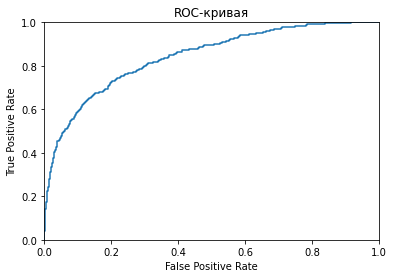

In [27]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 


**Общий вывод** 

Для выполнения задания нам необходимо было сформировать модель, которая будет предсказывать уйдет ли клиент с обслужиания из банка или нет.

В соответствии с условиями задания, была составлена такая модель, однако результативность модели не соответствует целевому показателю f1 > 0.59.

Недостижение цели обусловлено перекосом в данных (ушедшие, оставшиеся клиенты), несмотря на то, что массив данных корректировался методомами увеличения и уменьшения выборки.

По результатам сравнения сформированной модели (наилучшие результаты показала модель с ументшенной выборкой) с моделью формирующей выводы случайным образом (ROC-AUC), наша модель показывает лучшие результаты: 0,5 и 0,8 соответвенно.

**Рекомендации**

Составленная модель не может быть использована для утверждения о том уйдет ли клиент или нет, однако ее результаты должны использоваться для формирования списков клиентов которые потенциально могут уйти из банка для предложения таким клиентам дополнителных или улучшенных условий обслуживания с целью их удержания.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [х]  Весь код выполняется без ошибок
- [х]  Ячейки с кодом расположены в порядке исполнения
- [х]  Выполнен шаг 1: данные подготовлены
- [х]  Выполнен шаг 2: задача исследована
    - [х]  Исследован баланс классов
    - [х]  Изучены модели без учёта дисбаланса
    - [х]  Написаны выводы по результатам исследования
- [х]  Выполнен шаг 3: учтён дисбаланс
    - [х]  Применено несколько способов борьбы с дисбалансом
    - [х]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [х]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*